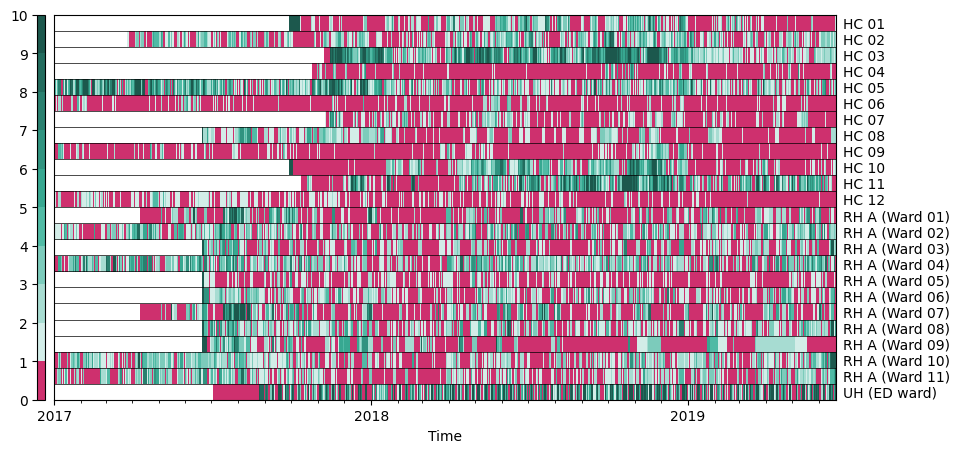

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from pyprojroot import here

data = pd.read_csv(here() / 'data/raw/data.csv', 
                   index_col='datetime', 
                   parse_dates=True,
                   low_memory=False)

# Some hospitals don't have any data prior to 2018 so we drop these
drop_these = ['HC_10', 
              'HC_11_(Ward_01)',
              'HC_11_(Ward_02)',
              'HC_11_(Ward_03)',
              'UH_(Ward_01)',
              'UH_(Ward_02)',
              'HC_14',
              'RH_B_(Ward_01)',
              'RH_B_(Ward_02)'
              ]

conversion = {
    'HC_12' : 'HC_10',
    'HC_13' : 'HC_11',
    'HC_15' : 'HC_12'
}

# colors
purple = (138/255, 97/255, 178/255)
green = (59/255, 178/255, 154/255)
red = (206/255, 48/255, 110/255)
yellow = (255/255, 226/255, 98/255)
dark_green = (28/255, 88/255, 77/255)
blue = (120/255, 192/255, 232/255)

mask = data.columns.str.startswith('Beds')
beds = data.loc[:,mask].resample('h').first()
indiv = beds.iloc[:,:]
indiv.columns = indiv.columns.str[5:]

# mask columns
indiv = indiv.drop(columns=drop_these)
indiv = indiv.rename(columns=conversion).copy()
indiv.columns = indiv.columns.str.replace('_', ' ')


# sort columns
sorted_columns = indiv.columns.sort_values(ascending=True)
indiv = indiv[sorted_columns]

fig, ax = plt.subplots(figsize=(12,5))

cmap = LinearSegmentedColormap.from_list("", ["white", green, dark_green], N=10)
#cmap.set_under([0.84, 0.19, 0.15, 1.00])
newcolors = cmap(range(10))
newcolors[0,:] = [206/255, 48/255, 110/255, 1.0]
cmap = ListedColormap(newcolors)

# datetime xaxis
x_lims = indiv.index[0], indiv.index[-1]
x_lims = mdates.date2num(x_lims)
y_lims = 0, indiv.shape[1]

# Major ticks every 6 months.
fmt_half_year = mdates.YearLocator()
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

neg = ax.imshow(indiv.T, extent = [x_lims[0], x_lims[1], y_lims[0], y_lims[1]], 
                 aspect='auto', cmap=cmap, vmax=10, vmin=0, interpolation='nearest');

# yaxis fixes
ax.yaxis.set_major_locator(plt.FixedLocator(range(33)));
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.tick_right()

# center y_ticklabels
ax.yaxis.set_minor_locator(plt.FixedLocator(np.arange(0.5, 33.5)));
ax.yaxis.set_major_locator(plt.FixedLocator(range(33)));
ax.yaxis.set_minor_formatter(plt.FixedFormatter(indiv.columns[::-1]))

for tick in ax.yaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    
for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)

# xaxis fixed
ax.xaxis_date()
ax.xaxis.tick_bottom()

#ax.set_title('Number of available beds')
ax.set_xlabel('Time')

cbar = fig.colorbar(neg, location='left', pad=.01, aspect=50);
ax.grid(axis='y', c='k', lw=.5)

# cbar fixes
cbar.ax.yaxis.set_major_locator(plt.MultipleLocator(1))
plt.savefig(here() / 'output/plots/beds.jpg', dpi=300, bbox_inches='tight')